In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()

# Tidy Tensors


In [ ]:
# | default_exp core

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
import numpy as np

In [ ]:
# | export


class Tensor:
    op = "L"
    name: str = ""
    parents: list = []

    def __init__(self, data, name=""):
        self.data = data
        self.name = name
        self.grad = np.zeros_like(self.data)

    # XXXX Fix broadcasting!
    def broadcast(self, other_shape):
        if self.data.shape == other_shape:
            return self

    def add(self, other, name):
        out = AddTensor(data=self.data + other.data, name=name)
        out.parents = [self, other]
        return out

    def sub(self, other, name):
        out = SubTensor(data=self.data - other.data, name=name)
        out.parents = [self, other]
        return out

    def mul(self, other, name):
        out = MulTensor(data=self.data * other.data, name=name)
        out.parents = [self, other]
        return out

    def mmul(self, other, name):
        out = MatMulTensor(data=np.matmul(self.data, other.data), name=name)
        out.parents = [self, other]
        return out

    def sum(self, name):
        out = SumTensor(data=self.data.sum(), name=name)
        out.parents = [self]
        return out

    def sigmoid(self, name):
        out = SigmoidTensor(data=1 / (1 + np.exp(-self.data)), name=name)
        out.parents = [self]
        return out

    def backward(self):
        # Create a list of all parent nodes, in reverse order
        # Start with the current node
        visited = []
        nodes = []

        def walk(node):
            for p in node.parents:
                if p not in visited:
                    visited.append(p)
                    walk(p)
                    nodes.append(p)

        walk(self)
        nodes.append(self)

        # print(nodes)
        self.grad = np.ones_like(self.data)
        for n in nodes[::-1]:
            if hasattr(n, "_backward"):
                n._backward()

    def __repr__(self):
        res = f"[{self.op or ''}] {self.name}={str(self.data)} {self.name}.grad={str(self.grad)}"
        if self.parents:
            res += (
                f" {self.name}.parents=[" + ",".join([p.name for p in self.parents]) + "]"
            )

        return f"Tensor({res})"


class AddTensor(Tensor):
    op = "+"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad += self.grad


class SubTensor(Tensor):
    op = "-"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad -= self.grad


class MulTensor(Tensor):
    op = "*"

    def _backward(self):
        self.parents[0].grad += self.grad * self.parents[1].data
        self.parents[1].grad += self.grad * self.parents[0].data


class MatMulTensor(Tensor):
    op = "@"

    def _backward(self):
        # print(self.grad)
        self.parents[0].grad += np.matmul(self.grad, self.parents[1].data.T)
        self.parents[1].grad += np.matmul(self.parents[0].data.T, self.grad)


class SumTensor(Tensor):
    op = "sum"

    def _backward(self):
        self.parents[0].grad += self.grad


class SigmoidTensor(Tensor):
    op = "sigmoid"

    def _backward(self):
        self.parents[0].grad += self.grad * self.data * (1 - self.data)

In [ ]:
a = Tensor(1, "a")
b = Tensor(2, "b")

c = a.add(b, "c")
d = a.mul(b, "d")
e = c.add(d, "e")


print(e)

e.grad = 1
# e.backward()

Tensor([+] e=5 e.grad=0 e.parents=[c,d])


In [ ]:
a = Tensor(np.ones((3, 4)), "a")
b = Tensor(np.ones((4, 3)) * 2, "b")

c = a.mmul(b, "c")
print(c)

s = c.sum("s")
print(s)
s.backward()

Tensor([@] c=[[8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]] c.grad=[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] c.parents=[a,b])
Tensor([sum] s=72.0 s.grad=0.0 s.parents=[c])


In [ ]:
s

Tensor([sum] s=72.0 s.grad=1.0 s.parents=[c])

In [ ]:
a.grad, b.grad

(array([[6., 6., 6., 6.],
        [6., 6., 6., 6.],
        [6., 6., 6., 6.]]),
 array([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]]))

In [ ]:
b_rand = Tensor(np.random.randn(4, 5), "b_rand")
a_rand = Tensor(np.random.randn(3, 4), "a_rand")

s = a_rand.mmul(b_rand, "c_rand").sum("s")
print(s)
s.backward()
print(a_rand.grad)
print(b_rand.grad)

Tensor([sum] s=2.2148644106887265 s.grad=0.0 s.parents=[c_rand])
[[ 1.33598911 -2.35323976  0.85234615 -0.82225416]
 [ 1.33598911 -2.35323976  0.85234615 -0.82225416]
 [ 1.33598911 -2.35323976  0.85234615 -0.82225416]]
[[-0.35446622 -0.35446622 -0.35446622 -0.35446622 -0.35446622]
 [-0.10999714 -0.10999714 -0.10999714 -0.10999714 -0.10999714]
 [ 0.08977331  0.08977331  0.08977331  0.08977331  0.08977331]
 [-2.8617184  -2.8617184  -2.8617184  -2.8617184  -2.8617184 ]]


In [ ]:
# | eval: false
import torch

a = torch.tensor(a_rand.data, requires_grad=True)
b = torch.tensor(b_rand.data, requires_grad=True)

c = (a @ b).sum()

c.backward()
a.grad, b.grad

(tensor([[ 1.3360, -2.3532,  0.8523, -0.8223],
         [ 1.3360, -2.3532,  0.8523, -0.8223],
         [ 1.3360, -2.3532,  0.8523, -0.8223]], dtype=torch.float64),
 tensor([[-0.3545, -0.3545, -0.3545, -0.3545, -0.3545],
         [-0.1100, -0.1100, -0.1100, -0.1100, -0.1100],
         [ 0.0898,  0.0898,  0.0898,  0.0898,  0.0898],
         [-2.8617, -2.8617, -2.8617, -2.8617, -2.8617]], dtype=torch.float64))

In [ ]:
# | eval: false
np.isclose(a_rand.grad, a.grad.numpy()).all()
np.isclose(b_rand.grad, b.grad.numpy()).all()

True

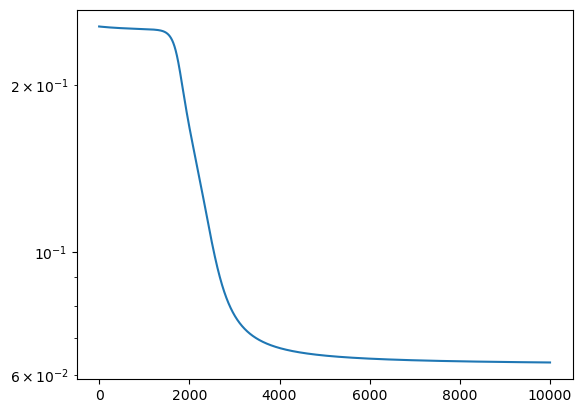

In [ ]:
#| eval: false

import matplotlib.pyplot as plt

X = [
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]

Y = [0, 1, 1, 0]

w1 = Tensor(np.random.randn(2, 3)*0.1, "w1")
b1 = Tensor(np.zeros((1, 3)), "b1")

w2 = Tensor(np.random.randn(3, 1)*0.1, "w2")

LR = 0.2

# print(w1, b1, w2)

losses = []

for i in range(10000):
    epoch_loss = 0
    for x, y in zip(X, Y):
        x = Tensor(np.array(x, dtype=float).reshape(1, 2), "x")
        y = Tensor(np.array(y, dtype=float).reshape(1, 1), "y")

        z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
        z2 = z1.mmul(w2, "z2").sigmoid("z2")

        loss = z2.sub(y, "loss").mul(z2.sub(y, "loss"), "loss").sum("loss")

        # print(loss)
        epoch_loss += loss.data

        loss.backward()

        w1.data -= LR * w1.grad
        b1.data -= LR * b1.grad
        w2.data -= LR * w2.grad

        w1.grad = np.zeros_like(w1.grad)
        b1.grad = np.zeros_like(b1.grad)
        w2.grad = np.zeros_like(w2.grad)

    losses.append(epoch_loss / len(X))

plt.plot(losses)
plt.yscale("log")